# 1. 项目介绍

- 项目数据集来自 Kaggle 网站公开的 Hotel booking demand 项目。
- 该数据集包含了一家城市酒店和一家度假酒店的预订信息，包括预订时间、入住时间、成人、儿童和/或婴儿数量、可用停车位数量等信息。
- 数据集已进行个人信息脱敏，容量约为12万×32。

---
- 本项目主要包含以下内容：
    - 完成对数据集的**数据预处理**；
    - 利用数据集对酒店运营状况/市场情况/客户画像进行**数据分析**；
    - 根据数据集建立**机器学习模型**，预测客户是否会取消预定。

# 2. 数据导入

In [1]:
# 导入库文件
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# 机器学习库
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
data_origin = pd.read_csv('./hotel_bookings.csv')
data_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
# 输出各列的取值
for column in data_origin.columns:
    print("列名: ", column)
    print('-'*25)
    print("类型: ", data_origin[column].dtype)
    print('-'*25)
    print(data_origin[column].value_counts().sort_values(ascending=False))
    print('-'*25)
    print('\n'*2)

列名:  hotel
-------------------------
类型:  object
-------------------------
City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64
-------------------------



列名:  is_canceled
-------------------------
类型:  int64
-------------------------
0    75166
1    44224
Name: is_canceled, dtype: int64
-------------------------



列名:  lead_time
-------------------------
类型:  int64
-------------------------
0      6345
1      3460
2      2069
3      1816
4      1715
       ... 
400       1
370       1
532       1
371       1
463       1
Name: lead_time, Length: 479, dtype: int64
-------------------------



列名:  arrival_date_year
-------------------------
类型:  int64
-------------------------
2016    56707
2017    40687
2015    21996
Name: arrival_date_year, dtype: int64
-------------------------



列名:  arrival_date_month
-------------------------
类型:  object
-------------------------
August       13877
July         12661
May          11791
October      11160
April        11089
Jun

In [4]:
print(data_origin.columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


数据列主要包含了以下3个方面信息

1.客户信息：客户自身属性信息

2.房间信息：酒店房间的价格/类型特征

3.订单信息：预定相关时间/状态信息

# 3. 数据清理

## 3.1 缺失值处理

- 统计出现缺失值的各列所包含的缺失值数目。

In [5]:
# 保留副本
data = data_origin.copy()
missing = data.isnull().sum(axis=0)
print(missing[missing != 0])

children         4
country        488
agent        16340
company     112593
dtype: int64


可见，共有四列出现缺失值，分别作出如下处理：

- children 和 country 列由于缺失数目较小，采用对应列众数进行填充；
- agent列缺失数目较多，将缺失值单独作为新类别，标记为0；
- company列几乎全为缺失值，不能提供足够信息，删除此列。

In [6]:
#缺失值处理

data.children.fillna(data.children.mode()[0], inplace=True)
data.country.fillna(data.country.mode()[0], inplace=True)

In [7]:
data.agent.fillna(0, inplace=True)
data.drop('company', inplace=True, axis=1)

## 3.2 异常值处理

- 数据集中存在入住总人数为0和总入住天数为0的异常数据，同样需要对这些数据进行筛选和清理。
- 同时，查询数据集说明可知，在 Meal 列中 Undefined / SC 均表示未预定餐食，应合并为同一类。

In [8]:
# 异常值处理 - 找到要删除的数据index, 利用 drop 语句进行删除。
# 入住人数为0
zero_guest = data[ data[['adults', 'children', 'babies']].sum(axis=1) == 0 ]
data.drop(zero_guest.index, inplace=True)

In [9]:
# 入住天数为0
zero_days = data[data[['stays_in_week_nights', 'stays_in_weekend_nights']].sum(axis=1) == 0]
data.drop(zero_days.index, inplace=True)

In [10]:
# 餐食类型 Undefined / SC 合并 - replace 语句 ：替代前, 替代后
data.meal.replace("Undefined", "SC", inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 118565 entries, 2 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118565 non-null  object 
 1   is_canceled                     118565 non-null  int64  
 2   lead_time                       118565 non-null  int64  
 3   arrival_date_year               118565 non-null  int64  
 4   arrival_date_month              118565 non-null  object 
 5   arrival_date_week_number        118565 non-null  int64  
 6   arrival_date_day_of_month       118565 non-null  int64  
 7   stays_in_weekend_nights         118565 non-null  int64  
 8   stays_in_week_nights            118565 non-null  int64  
 9   adults                          118565 non-null  int64  
 10  children                        118565 non-null  float64
 11  babies                          118565 non-null  int64  
 12  meal            

In [11]:
# 最后检查一遍是否有缺失值 : 输出空集，不存在任何缺失值。
data.isnull().sum()[data.isnull().sum() != 0]

Series([], dtype: int64)

- 数据清理完成，数据集大小变为118565×31。

# 4. 数据可视化

- 主要看各指标与 是否取消认定 之间的关系。

## 4.1 客房信息分析

### ① 酒店类型

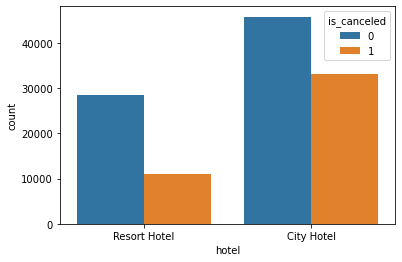

In [12]:
# 查看酒店类型与取消预定的关系
# countplot - 解析：使用条形图(柱状图)显示每个分类数据中的数量统计
sns.countplot(
    x='hotel',
    hue='is_canceled',
    data=data
)
plt.show()

- 城市酒店订单量明显超过度假酒店，但同时预订取消的可能性也远远高于度假酒店。

### ② 客房类型

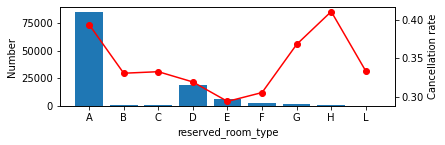

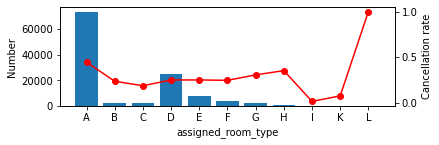

In [13]:
index = 1
for room_type in ['reserved_room_type', 'assigned_room_type']:
    ax1 = plt.subplot(2, 1, index)
    index += 1
    ax2 = ax1.twinx()
    # ax1 显示数量
    ax1.bar(
        data.groupby(room_type).size().index,
        data.groupby(room_type).size()
    )
    ax1.set_xlabel(room_type)
    ax1.set_ylabel('Number')
    # ax2 显示取消率
    ax2.plot(
        data.groupby(room_type)['is_canceled'].mean(), 'ro-'
    )
    ax2.set_ylabel('Cancellation rate')
    plt.show()

- 订单预定和分配的房间类型多数集中在A/D/E/F四类，其中A类房型取消率高出其余三类约7-8个百分点，值得关注。

进一步探索房间类型的变更（即分配房型≠预定房型）对于取消率的影响。

<AxesSubplot:xlabel='room_chaged', ylabel='count'>

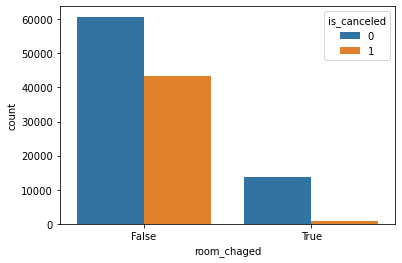

In [14]:
# 房间类型变更对取消预定的影响
# 返回布尔数组
data['room_chaged'] = data['reserved_room_type'] != data['assigned_room_type']
sns.countplot(x='room_chaged', hue='is_canceled', data=data)

房型变更过的客户取消预定的概率远远小于未变更过的客户，可能有以下原因：

①客户到达酒店后临时更改房型，多数客户会选择不取消预定，直接入住；

②客户自行更改房型，相对取消预定而言，这类客户更愿意更改房间类型而保证正常入住。

## 4.2 客户信息分析
### ① 入住人数

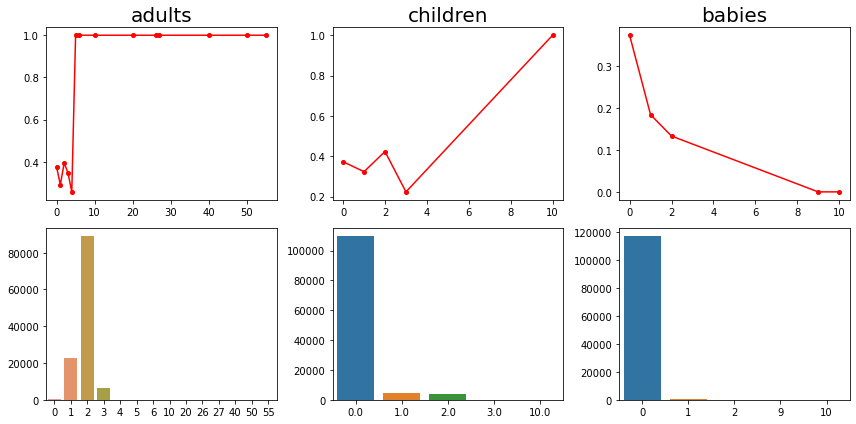

In [15]:
# 查看预定人数与取消预定的关系
plt.figure(figsize=(12, 6))
index = 0

for people in ['adults', 'children', 'babies']:
    index += 1
    plt.subplot(2, 3, index)
    # 上：预定人数与取消率的关系
    plt.plot(
        data.groupby(people)['is_canceled'].mean(),
        'ro-',
        ms=4
    )
    plt.title(people, fontsize=20)
    plt.subplot(2, 3, index+3)
    people_stats = data[people].value_counts()
    # 下：预定人数分布
    sns.barplot(people_stats.index, people_stats.values)
plt.tight_layout()
plt.show()

1）多数预定订单没有儿童和婴儿入住，其中单人入住和双人入住是主要的预定人数模式；

2）有婴儿入住时预定取消率大幅下降；

3）超过5人以上入住的订单基本全部取消，这部分可能是刷单等异常订单，酒店需要注意。


针对不同酒店，重点分析下列几种入住人数情况的取消率：

- 单人入住：adults=1, children, babies=0；
- 双人入住：adults=2, children, babies=0；
- 家庭入住：adults>2, children, babies>0。

In [16]:
# 入住人数模式分析 : 取个代号
# 单人
single = (data.adults == 1) & (data.children == 0) & (data.babies == 0)
# 双人
couple = (data.adults == 2) & (data.children == 0) & (data.babies == 0)
# 家庭
family = (data.adults >= 2) & (data.children > 0) | (data.babies > 0)

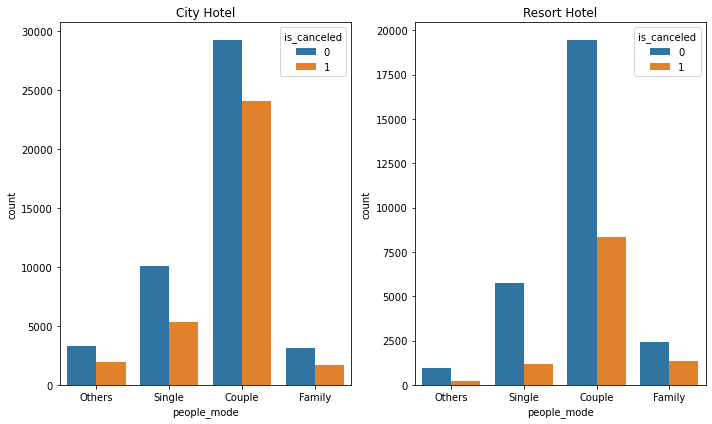

In [17]:
data['people_mode'] = single.astype(int) + couple.astype(int) * 2 + family.astype(int) * 3
plt.figure(figsize=(10, 6))
index = 1
for hotel_kind in ['City Hotel', 'Resort Hotel']:
    plt.subplot(1, 2, index)
    index += 1
    sns.countplot(
        x='people_mode',
        hue='is_canceled',
        data=data[data.hotel == hotel_kind]
    )
    plt.xticks([0, 1, 2, 3], ['Others', 'Single', 'Couple', 'Family'])
    plt.title(hotel_kind)
plt.tight_layout()
plt.show()

- 对于城市酒店，取消预定概率：双人>>单人≈家庭，应注意双人入住客户的高取消率现象，改善酒店对于双人入住客户的配套服务以降低取消率。

- 对于度假酒店，取消预订概率：家庭>双人>单人，酒店可适当针对家庭客户提供相应的优惠折扣，提高家庭客户入住率。

### ② 餐食类型

Text(0.5, 1.0, 'Uncanceled')

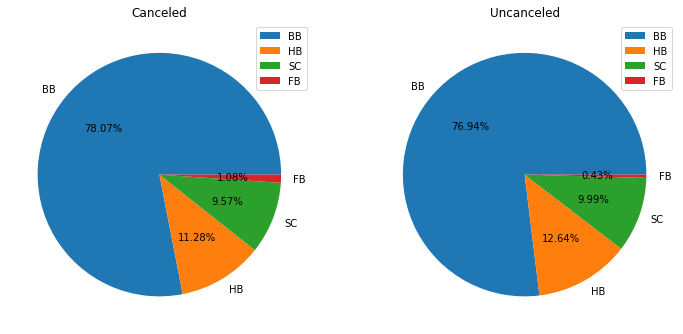

In [18]:
# 查看餐食类型与取消预定的关系
plt.figure(figsize=(12, 6))


# 取消预定情况下的饼图分布
plt.subplot(121)
plt.pie(
    data[data['is_canceled'] == 1].meal.value_counts(),
    labels=data[data['is_canceled'] == 1].meal.value_counts().index,
    autopct='%.2f%%'
)
plt.legend(loc=1)
plt.title('Canceled')


# 未取消预定情况下的饼图分布
plt.subplot(122)
plt.pie(
    data[data['is_canceled'] == 0].meal.value_counts(),
    labels=data[data['is_canceled'] == 0].meal.value_counts().index,
    autopct='%.2f%%'
)
plt.legend(loc=1)
plt.title('Uncanceled')

### ③ 车位需求

<AxesSubplot:xlabel='required_car_parking_spaces', ylabel='count'>

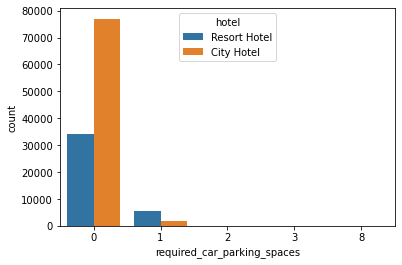

In [19]:
# 车位需求统计
sns.countplot(x='required_car_parking_spaces', hue='hotel', data=data)

- 多数客户不需要停车位，相比之下，度假酒店客户需要停车位的比例远大于城市酒店。

### ④ 国家/地区

- 数据集客户来自177个国家/地区，为方便分析，只选择预定数前20的国家/地区进行分析。

Text(0, 0.5, 'Cancellation rate')

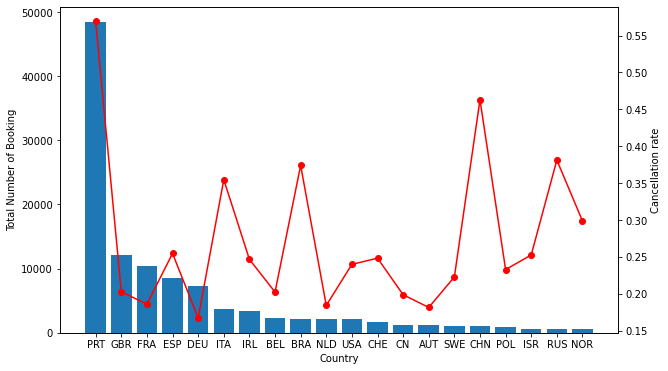

In [20]:
# 查看不同国家订单取消率
# 选取预定数前20个国家/地区

countries_20 = list(
    data.groupby('country').size().sort_values(ascending=False).head(20).index
)
# 前20个国家占比 94.21%
data[data.country.isin(countries_20)].shape[0] / data.shape[0]


# 绘制订单数量
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
plt.xticks(range(20), countries_20)
ax1.bar(
    range(20),
    data[data.country.isin(countries_20)].groupby('country').size().sort_values(ascending=False)
)
ax1.set_xlabel('Country')
ax1.set_ylabel('Total Number of Booking')


# 绘制取消率
ax2.plot(
    range(20),
    # 按 loc[countries_20] 的顺序进行显示
    data[data.country.isin(countries_20)].groupby('country')['is_canceled'].mean().loc[countries_20],
    'ro-'
)
ax2.set_ylabel('Cancellation rate')

- 统计可知，前20名国家/地区数据量占据全部数据的94%，客户主要来自葡萄牙，英国，法国，西班牙等欧洲国家。
- 不同国家之间预定取消率的差距非常显著，取消率较高的国家有葡萄牙、意大利、巴西、中国、俄罗斯，以发展中国家为主。

### ⑤ 客户预定历史
- 客户预定历史指客户之前预定过的订单的取消情况，可以一定程度上反映客户当前订单的取消意愿。

([<matplotlib.axis.XTick at 0x25c36338ee0>,
 [Text(0, 0, 'New Guest'), Text(1, 0, 'Repeated Guest')])

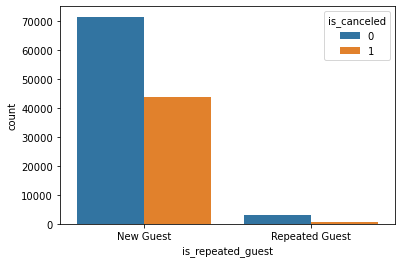

In [21]:
# 查看客户预定历史与取消订单的关系
# 是否回头客
tick_label = ['New Guest', 'Repeated Guest']
sns.countplot(
    x='is_repeated_guest',
    hue='is_canceled',
    data=data
)
plt.xticks([0, 1], tick_label)

Text(0.5, 0, 'Previous Un-Cancellations')

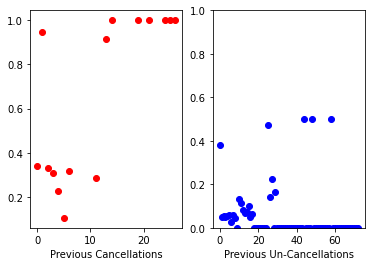

In [22]:
# 之前取消预定次数
plt.subplot(121)
plt.plot(
    data.groupby('previous_cancellations')['is_canceled'].mean(),
    'ro'
)
plt.xlabel('Previous Cancellations')

# 之前未取消预定次数
plt.subplot(122)
plt.plot(
    data.groupby('previous_bookings_not_canceled')['is_canceled'].mean(),
    'bo'
)
plt.ylim(0, 1)
plt.xlabel('Previous Un-Cancellations')

1）大多数预定来自于新客，而熟客取消预定的概率远远小于新客；

2）先前取消过预定的客户本次预定取消的概率较大，尤其是取消过预定15次以上的客户，基本上不会选择入住，可以计入酒店的“黑名单”；

3）先前预定并入住过的客户相对来说信用较好，高入住次数（>20次）客户基本不会取消预订。

## 4.3 订单信息分析
### ① 提前预定时长

Text(0, 0.5, 'Cancellation rate')

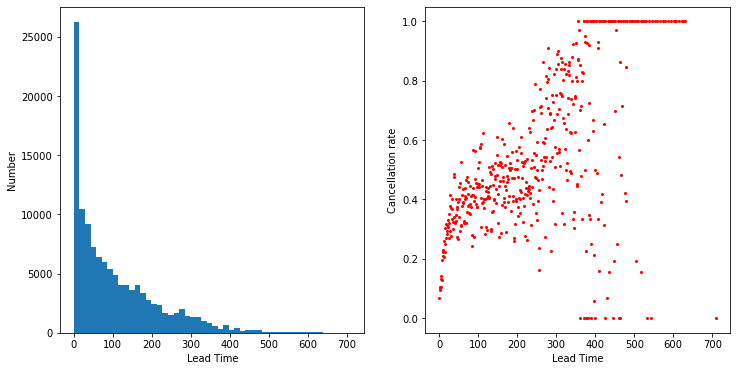

In [23]:
# 提前预定时长的分部情况
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(data['lead_time'], bins=50)
plt.xlabel('Lead Time')
plt.ylabel('Number')


# 提前预定时长对取消的影响
plt.subplot(122)
plt.plot(
    data.groupby('lead_time')['is_canceled'].mean().index,
    data.groupby('lead_time')['is_canceled'].mean(),
    'ro',
    markersize=2
)
plt.xlabel('Lead Time')
plt.ylabel('Cancellation rate')

- 从预定提前时长分布明显可以看出，客户倾向于选择与入住时间相近的时间预定，并且随着预定提前时长的增大，取消率呈现上升趋势。

### ② 入住时间

- 数据集时间跨度为2015年7月-2017年8月，研究不同月份的预定取消情况。

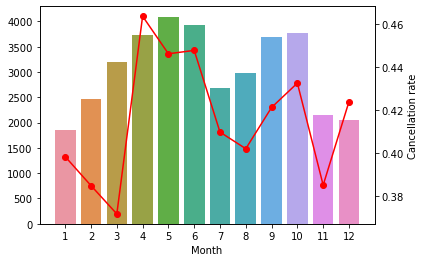

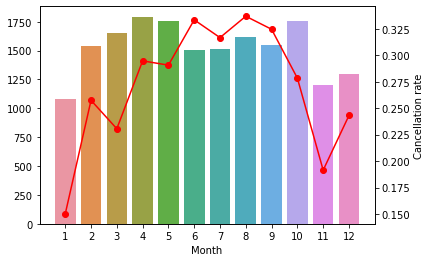

In [24]:
# 不同月份预定和取消情况
ordered_months = [
    "January", "February", "March", "April", "May", "June", "July", "August",
    "September", "October", "November", "December"
]

for hotel in ['City Hotel', 'Resort Hotel']:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    data_hotel = data[data.hotel == hotel]
    monthly = data_hotel.groupby('arrival_date_month').size()
    monthly /= 2
    monthly.loc[['July', 'August']] = monthly.loc[['July', 'August']] * 2 / 3
    # ax1 绘制订单数量
    sns.barplot(list(range(1, 13)), monthly[ordered_months], ax=ax1)


    # ax2 绘制取消预定率
    ax2.plot(
        range(12),
        data_hotel.groupby('arrival_date_month')['is_canceled'].mean()[ordered_months].values,
        'ro-'
    )
    ax1.set_xlabel('Month')
    ax2.set_ylabel('Cancellation rate')

1）预定量上，城市酒店7/8月出现大幅下滑，同期度假酒店变化较小，整体而言，度假酒店月度客流量变化较小；

2）取消率上，两家酒店冬季取消率相对较低，城市酒店夏季取消率降低，度假酒店却处于高峰。

结合酒店人均价格波动进行分析

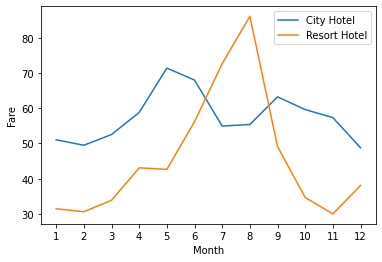

In [25]:
# 不同酒店人均价格波动
# 人均价格(不考虑 babies)

data['adr_per_person'] = data['adr'] / (data['adults'] + data['children'])
plt.plot(
    # [ordered_months] 的作用是，按 list 中的元素的顺序进行展示
    data[data.hotel == 'City Hotel'].groupby('arrival_date_month')['adr_per_person'].mean()[ordered_months],
    label='City Hotel'
)

plt.plot(
    # [ordered_months] 的作用是，按 list 中的元素的顺序进行展示
    data[data.hotel == 'Resort Hotel'].groupby('arrival_date_month')['adr_per_person'].mean()[ordered_months],
    label='Resort Hotel'
)

plt.xlabel('Month')
plt.ylabel('Fare')
plt.xticks(np.arange(12), range(1, 13))
plt.legend()

- 两种酒店客房价格趋势主要差异在于7-8月，此时期城市酒店价格小幅下跌，度假酒店价格却急速上涨，一度超过城市酒店。

- 结合预定量和取消量分析，7-8月度假酒店客流减少，取消率大幅上升，经营者应考虑调整价格策略以增加营收。

- 对于用户而言，应考虑避免8月预定度假酒店，此时酒店价格处于高位，而9月价格便会下跌近一半，气候/环境差异不大，是入住的好时期。

### ③ 入住时长

In [26]:
# 周末和工作日取消率
# 工作日
data[data['stays_in_weekend_nights'] == 0]['is_canceled'].mean()

0.3797463414634146

In [27]:
# 周末
data[data['stays_in_weekend_nights'] != 0]['is_canceled'].mean()


0.36713956770407785

周末和工作日的订单取消率没有明显差异，进一步研究入住时长的影响。

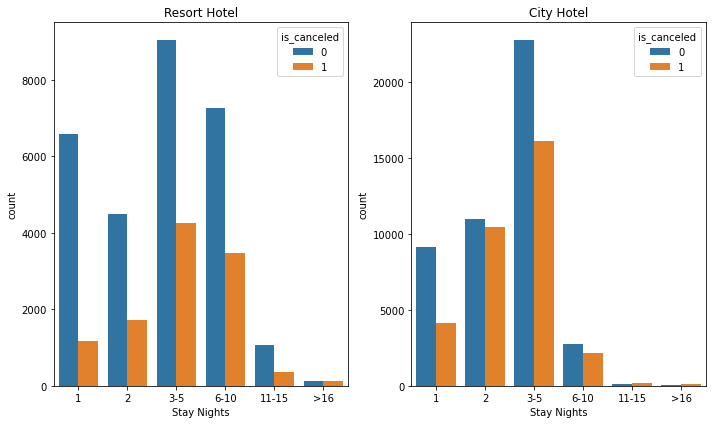

In [28]:
# 预定入住时长对取消预定的影响
data['stay_nights'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
# 分布过散，进行数据分桶
bin = [0, 1, 2, 5, 10, 15, np.inf]
data['stay_nights_bin'] = pd.cut(
    data['stay_nights'],
    bin,
    labels=['1', '2', '3-5', '6-10', '11-15', '>16']
)
plt.figure(figsize=(10, 6))


# 预定度假酒店情况下，预定晚数与是否取消之间的关系图
plt.subplot(121)
sns.countplot(
    x='stay_nights_bin',
    hue='is_canceled',
    data=data[data['hotel'] == 'Resort Hotel']
)
plt.xlabel('Stay Nights')
plt.title('Resort Hotel')


# 预定酒店酒店情况下，预定晚数与是否取消之间的关系图
plt.subplot(122)
sns.countplot(x='stay_nights_bin', hue='is_canceled',
              data=data[data['hotel'] == 'City Hotel'])
plt.xlabel('Stay Nights')
plt.title('City Hotel')
plt.tight_layout()
plt.show()

1）度假酒店客户入住时长集中在1-10晚，其中入住1晚的客户取消概率最低；

2）城市酒店客户入住时长多在5晚以内，其中入住2晚的客户取消概率最高；

3）整体而言，度假酒店客户平均入住天数明显高于城市酒店，可以考虑推出长租优惠方案吸引顾客。

### ⑤ 预定渠道

Text(0, 0.5, 'Rate')

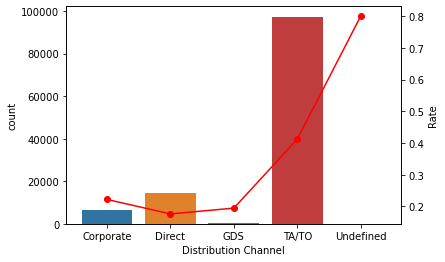

In [29]:
# 预定渠道对取消率的影响
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# 绘制订单数量
sns.countplot(
    x=data['distribution_channel'],
    # order x轴展示顺序
    order=data.groupby('distribution_channel')['is_canceled'].mean().index,
    ax=ax1
)
ax1.set_xlabel('Distribution Channel')


# 绘制取消率
ax2.plot(data.groupby('distribution_channel')['is_canceled'].mean(), 'ro-')
ax2.set_ylabel('Rate')

1）预定主要来自于旅行社(TA/TO)，个人直接预定(Direct)和团体预定(Group)；

2）旅行社取消预定的概率远大于其他渠道，可能是由于旅行社出于盈利考虑会取消利润较低的订单。

# 5. 构建预测模型

首先进行特征的筛选，模型目标是对订单是否取消进行预测，挑选特征变量应满足：

1）特征必须为客户预定时就能获得的数据，因此排除booking_changes（预定更改），reservation_status（结账状态），assigned_room_type （最终分配房型）等特征。

2）考虑一定的信息脱敏和通用性，排除country（国籍），arrival_date_year（入住年份）等特征。

In [30]:
num = [
    'lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month',
    'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
    'babies', 'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'agent', 'required_car_parking_spaces',
    'total_of_special_requests', 'adr', 'adr_per_person'
]

cat = [
    'hotel', 'arrival_date_month', 'meal', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'deposit_type',
    'customer_type'
]

target = ['is_canceled']

ref = num + cat + target
train = data[ref]

In [31]:
# 处理类别变量
# LabelEncoder().fit_transform : 将类别变量转换为对应的数字

train[cat] = train[cat].apply(LabelEncoder().fit_transform)

In [32]:
print(train.shape)
print('-'*25*2)
# 分离特征变量和目标变量
print(train.info())


# 思考：LabelEncoder().fit_transform 转换后的特征，涉及数字大小，使用 One-Hot 编码转变可能更合适。

(118565, 25)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 118565 entries, 2 to 119389
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       118565 non-null  int64  
 1   arrival_date_week_number        118565 non-null  int64  
 2   arrival_date_day_of_month       118565 non-null  int64  
 3   stays_in_weekend_nights         118565 non-null  int64  
 4   stays_in_week_nights            118565 non-null  int64  
 5   adults                          118565 non-null  int64  
 6   children                        118565 non-null  float64
 7   babies                          118565 non-null  int64  
 8   is_repeated_guest               118565 non-null  int64  
 9   previous_cancellations          118565 non-null  int64  
 10  previous_bookings_not_canceled  118565 non-null  int64  
 11  agent         

完成数据列处理后，先查看一下各数据参数与取消预订之间的相关性。

<AxesSubplot:>

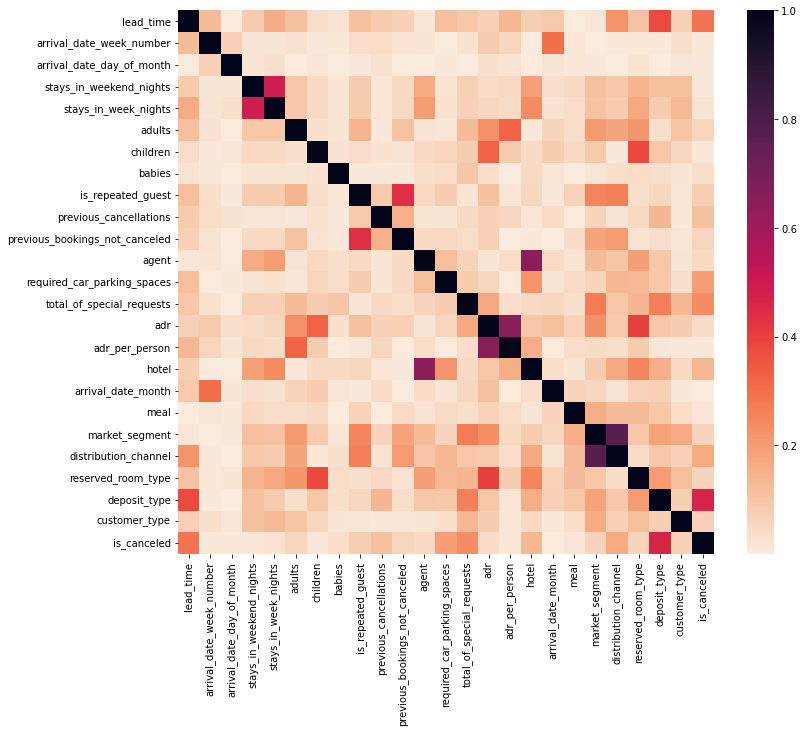

In [33]:
# 查看各列与取消预定的相关系数
plt.figure(figsize=(12, 10))
sns.heatmap(train.corr().abs(), cmap=sns.cm.rocket_r)

- 与取消预订相关性较高的特征有：**提前预定时长，车位需求数，特殊需求数，押金类型，酒店类型**等。

接下来，进行模型训练，引入多个分类模型，均采用默认参数，简单比较模型之间的准确率。

In [34]:
# 分离特征变量和目标变量
X = train.drop(['is_canceled'], axis=1)
y = train['is_canceled']

In [35]:
X.describe()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,adr,adr_per_person,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type
count,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,...,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000
mean,104.505832,27.157028,15.799595,0.932096,2.512790,1.860009,0.104196,0.007962,0.029511,0.087631,...,102.523809,55.425894,0.334551,5.489672,0.544461,4.930570,2.588082,0.988808,0.125762,2.137680
std,106.915519,13.589350,8.782227,0.995462,1.893258,0.575441,0.399119,0.097560,0.169235,0.847172,...,50.005542,28.864821,0.471835,3.536675,1.039651,1.263951,0.905142,1.695226,0.335678,0.577563
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.380000,-3.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,70.000000,37.500000,0.000000,2.000000,0.000000,4.000000,3.000000,0.000000,0.000000,2.000000
50%,70.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,95.000000,49.500000,0.000000,6.000000,0.000000,5.000000,3.000000,0.000000,0.000000,2.000000
75%,161.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,126.000000,66.250000,1.000000,8.000000,0.000000,6.000000,3.000000,3.000000,0.000000,2.000000
max,709.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,...,5400.000000,2700.000000,1.000000,11.000000,3.000000,7.000000,4.000000,8.000000,2.000000,3.000000


In [36]:
# 特征缩放
std_sca = StandardScaler()
X = std_sca.fit_transform(X)

In [37]:
# 引入模型
MLA = [
    # 线性回归
    LogisticRegression(n_jobs=-1, random_state=42),
    # 梯度下降分类方法
    SGDClassifier(n_jobs=-1, random_state=42),
    RidgeClassifier(random_state=42),
    # 感知机
    Perceptron(n_jobs=-1, random_state=42),
    # 线性SVM
    LinearSVC(random_state=42),
    # 决策树
    DecisionTreeClassifier(random_state=42),
    # 随机森林
    RandomForestClassifier(n_jobs=-1, random_state=42),
    # K近邻
    KNeighborsClassifier(n_jobs=-1),
    # 高斯NB
    GaussianNB()
]


MLA_columns = [
    'MLA Name', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Test F1 Score', 'Time'
]

In [38]:
MLA_compare = pd.DataFrame(
    # len(MLA) 行数， len(MLA_columns) 列数。用 0 去填充。
    np.zeros([len(MLA), len(MLA_columns)]),
    columns=MLA_columns
)

row_index = 0
for alg in MLA:
    MLA_compare.iloc[row_index, 0] = alg.__class__.__name__
    cv_results = cross_validate(alg, X, y, scoring=('accuracy', 'f1'), cv=3, return_train_score=True)
    MLA_compare.iloc[row_index, 1] = round(cv_results['train_accuracy'].mean() * 100, 3)
    MLA_compare.iloc[row_index, 2] = round(cv_results['test_accuracy'].mean() * 100, 3)
    MLA_compare.iloc[row_index, 3] = round(cv_results['test_f1'].mean() * 100, 3)
    MLA_compare.iloc[row_index, 4] = cv_results['fit_time'].mean()
    row_index += 1

In [39]:
MLA_compare

,MLA Name,Train Accuracy Mean,Test Accuracy Mean,Test F1 Score,Time
0,LogisticRegression,80.132,72.960,48.995,3.988116
1,SGDClassifier,77.898,74.692,49.119,0.436944
2,RidgeClassifier,77.748,74.260,51.739,0.076198
3,Perceptron,72.881,67.486,48.864,0.175030
4,LinearSVC,79.583,73.028,47.711,19.132199
5,DecisionTreeClassifier,99.257,61.807,46.564,0.511095
6,RandomForestClassifier,99.256,67.209,49.051,2.714027
7,KNeighborsClassifier,88.422,64.123,46.867,0.015670
8,GaussianNB,47.134,51.702,50.211,0.032016


- 初步结果判断，决策树、随机森林、K近邻模型明显过拟合，高斯NB模型、线性SVM明显欠拟合。

获取最佳模型需要进行繁琐复杂的超参数调优工作，在此以岭回归和随机森林模型为例，使用网格搜索方法，进行模型微调。

In [40]:
# 模型微调
# 岭回归调优
# 网格搜索
# 岭回归调优
cv = 3

rid_clf = RidgeClassifier(random_state=42)
param_grid = {'alpha': [0.1, 0.3, 0.5, 1, 3, 5, 10]}
grid_search = GridSearchCV(rid_clf, param_grid, cv=cv, n_jobs=-1,return_train_score=True)
grid_search.fit(X, y)
print('train accuracy:',round(grid_search.cv_results_['mean_train_score'].mean() * 100, 3))
print('test accuracy:',round(grid_search.best_score_ * 100, 3))

train accuracy: 77.748
test accuracy: 74.261


In [41]:
# 决策树调优
for_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 110, 120, 130, 140],
    'max_features': [5, 10, 15]
}
grid_search = GridSearchCV(for_clf, param_grid, cv=cv, n_jobs=-1, return_train_score=True)
grid_search.fit(X, y)
round(grid_search.best_score_ * 100, 3)
print('train accuracy:', round(grid_search.cv_results_['mean_train_score'].mean() * 100, 3))
print('test accuracy:', round(grid_search.best_score_ * 100, 3))

train accuracy: 99.257
test accuracy: 67.303


- 网格参数使得模型的准确率得到较小的提升。
- 在模型预测准确率相对较好的情况下，参数调优带来的效果一般比较有限，后续如果想继续提升模型拟合效果，可以考虑采用特征工程/模型融合等进阶方法。